In [ ]:
from google.colab import files
files.upload()  # Upload the kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"niladrigiri","key":"d60d37ba6a308a6e68efd66f5d197f50"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d yasserhessein/tuberculosis-chest-x-rays-images -p /content --unzip

Dataset URL: https://www.kaggle.com/datasets/yasserhessein/tuberculosis-chest-x-rays-images
License(s): CC-BY-SA-4.0
  0% 0.00/26.3M [00:00<?, ?B/s]
100% 26.3M/26.3M [00:00<00:00, 696MB/s]


In [ ]:
# Importing libraries
import cv2
import numpy as np
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, roc_auc_score, f1_score

In [ ]:
data_dir = Path("/content/Dataset of Tuberculosis Chest X-rays Images")
classes = ["Normal Chest X-rays", "TB Chest X-rays"]

# Load images using OpenCV
X, y = [], []

for label, cls in enumerate(classes):
    cls_path = data_dir / cls
    for img_path in cls_path.iterdir():
        img = cv2.imread(str(img_path))
        if img is None:
            continue                                # skip corrupted images
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR → RGB
        img = cv2.resize(img, (128, 128))
        X.append(img)
        y.append(label)

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)

print(f"Loaded images: {X.shape}, Labels: {y.shape}")

Loaded images: (3008, 128, 128, 3), Labels: (3008,)


In [ ]:
# Split into train/val/test
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=5, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=5, stratify=y_temp)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (2105, 128, 128, 3), Val: (452, 128, 128, 3), Test: (451, 128, 128, 3)


# EDA

In [ ]:
# Image Count

print("Total images:", X.shape[0])
print("Image shape:", X.shape[1:])

Total images: 3008
Image shape: (128, 128, 3)


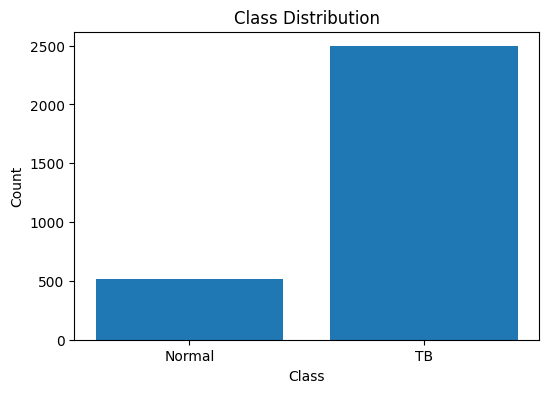

In [ ]:
import matplotlib.pyplot as plt
# Class Balance

class_names = ['Normal', 'TB']
counts = [np.sum(y == 0), np.sum(y == 1)]

plt.figure(figsize=(6,4))
plt.bar(class_names, counts)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

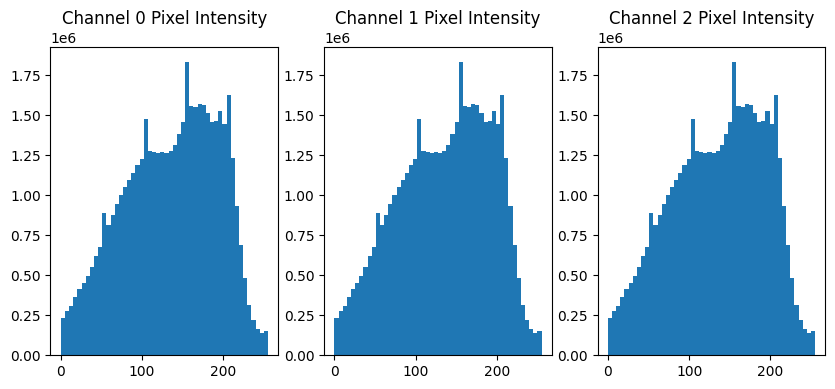

In [ ]:
# Pixel Intensity Distribution

channels = 3
plt.figure(figsize=(10,4))
for c in range(channels):
    plt.subplot(1, channels, c+1)
    plt.hist(X[:,:,:,c].ravel(), bins=50)
    plt.title(f'Channel {c} Pixel Intensity')
plt.show()

In [ ]:
# Mean and Std per channel

means = np.mean(X, axis=(0,1,2))
stds = np.std(X, axis=(0,1,2))
for i in range(channels):
    print(f"Channel {i}: Mean={means[i]:.2f}, Std={stds[i]:.2f}")

Channel 0: Mean=87.15, Std=71.14
Channel 1: Mean=87.15, Std=71.14
Channel 2: Mean=87.15, Std=71.14


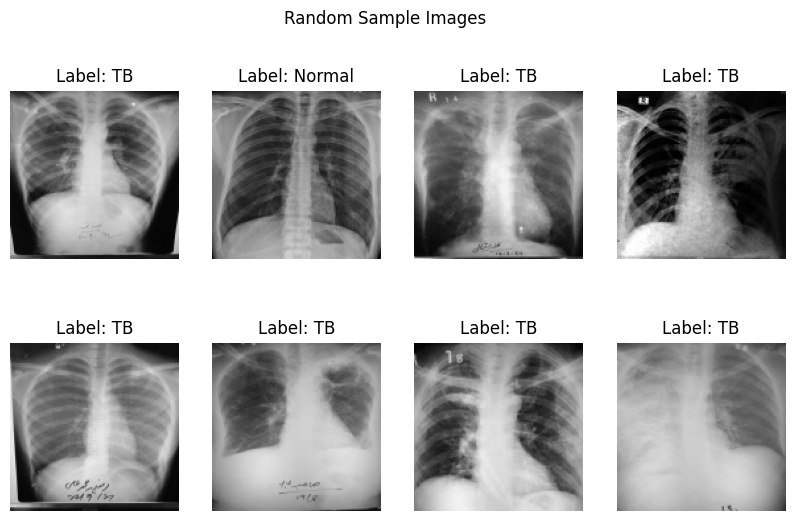

In [ ]:
# Random Sample Visualization

plt.figure(figsize=(10,6))
for i in range(8):
    idx = np.random.randint(0, X.shape[0])
    plt.subplot(2,4,i+1)
    plt.imshow(X[idx].astype(np.uint8))
    plt.title(f"Label: {class_names[y[idx]]}")
    plt.axis('off')
plt.suptitle("Random Sample Images")
plt.show()

In [ ]:
# Data augmentation layer
data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.05),
    RandomTranslation(0.05, 0.05),
    RandomBrightness(0.05),
    GaussianNoise(0.05)
])

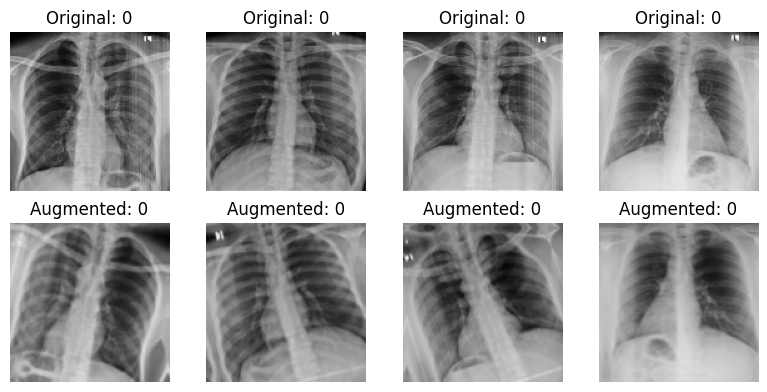

In [ ]:
# Plotting original vs augmented images

temp_ds = tf.data.Dataset.from_tensor_slices((X[:8], y[:8])).batch(4)

# ----- Take one batch -----
for images, labels in temp_ds.take(1):
    # Take first 4 images
    original_images = images[:4]
    augmented_images = data_augmentation(original_images, training=True)

    plt.figure(figsize=(8, 4))

    for i in range(4):
        # Top row: original
        ax = plt.subplot(2, 4, i + 1)
        img = original_images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.title(f"Original: {labels[i].numpy()}")
        plt.axis("off")

        # Bottom row: augmented
        ax = plt.subplot(2, 4, i + 5)
        img_aug = augmented_images[i].numpy().astype("uint8")
        plt.imshow(img_aug)
        plt.title(f"Augmented: {labels[i].numpy()}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    break

In [ ]:
# Create TensorFlow Datasets

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [ ]:
# Apply data augmentation
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Divide into batches
train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
class_weight = {0:3, 1:1}

In [ ]:
# Early Stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

## VGG16 Model

In [ ]:
# VGG16
conv_base = VGG16(
    weights = 'imagenet',
    include_top = False
)
conv_base.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from keras.applications.vgg16 import preprocess_input

# Model
input = Input(shape = (128,128,3))
x = preprocess_input(input)
x = conv_base(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation= 'sigmoid')(x)

model = Model(input, output)

In [ ]:
model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=15, callbacks= early_stop, class_weight= class_weight)

Epoch 1/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 340ms/step - accuracy: 0.6509 - loss: 2.2718 - val_accuracy: 0.8385 - val_loss: 0.5738
Epoch 2/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 272ms/step - accuracy: 0.8754 - loss: 0.6218 - val_accuracy: 0.8761 - val_loss: 0.4525
Epoch 3/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 240ms/step - accuracy: 0.9132 - loss: 0.3555 - val_accuracy: 0.9292 - val_loss: 0.1984
Epoch 4/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 247ms/step - accuracy: 0.9413 - loss: 0.2483 - val_accuracy: 0.9358 - val_loss: 0.1962
Epoch 5/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 240ms/step - accuracy: 0.9400 - loss: 0.2512 - val_accuracy: 0.9668 - val_loss: 0.0977
Epoch 6/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 250ms/step - accuracy: 0.9576 - loss: 0.2219 - val_accuracy: 0.9602 - val_loss: 0.1289
Epoch 7/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 237ms/step - accuracy: 0.9603 - loss: 0.2201 - val_accuracy: 0.9535 - val_loss: 0.1583
Epoch 8/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 261ms/step - accuracy: 0.9590 - loss: 0.1917 - val_accu

In [ ]:
# Prediction
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        77
           1       1.00      0.98      0.99       374

    accuracy                           0.98       451
   macro avg       0.96      0.99      0.97       451
weighted avg       0.99      0.98      0.98       451

ROC-AUC: 0.9906417112299466
F1 score: 0.99055330634278


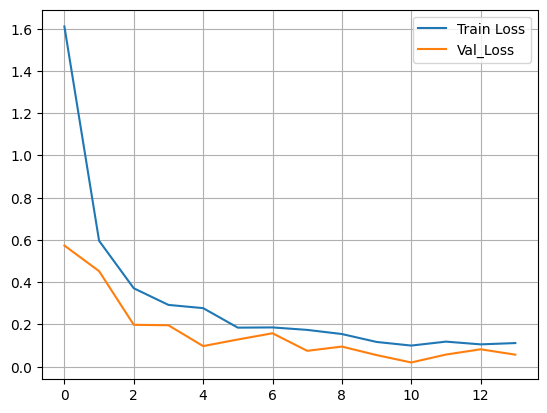

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label= 'Train Loss')
plt.plot(history.history['val_loss'], label= 'Val_Loss')
plt.grid()
plt.legend()
plt.show()

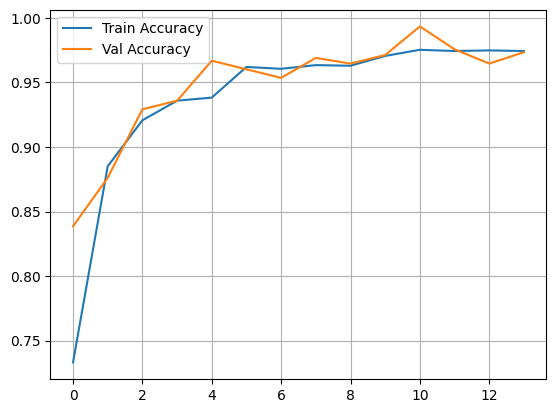

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label= 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label= 'Val Accuracy')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Save the model
model.save('vgg16.keras')

## ResNet50 Model

In [ ]:
#ResNet50
conv_base = ResNet50(
    weights = 'imagenet',
    include_top = False
)
conv_base.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

# Model
input = Input(shape = (128,128,3))
x = preprocess_input(input)
x = conv_base(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation= 'sigmoid')(x)

model = Model(input, output)

In [ ]:
model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=15, callbacks= early_stop, class_weight= class_weight)

Epoch 1/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 444ms/step - accuracy: 0.7940 - loss: 0.6250 - val_accuracy: 0.9580 - val_loss: 0.1218
Epoch 2/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 211ms/step - accuracy: 0.9317 - loss: 0.2285 - val_accuracy: 0.9757 - val_loss: 0.0843
Epoch 3/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 219ms/step - accuracy: 0.9703 - loss: 0.1226 - val_accuracy: 0.9823 - val_loss: 0.0587
Epoch 4/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 210ms/step - accuracy: 0.9757 - loss: 0.1023 - val_accuracy: 0.9889 - val_loss: 0.0386
Epoch 5/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 215ms/step - accuracy: 0.9713 - loss: 0.1027 - val_accuracy: 0.9779 - val_loss: 0.0470
Epoch 6/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 209ms/step - accuracy: 0.9854 - loss: 0.0666 - val_accuracy: 0.9845 - val_loss: 0.0348
Epoch 7/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 206ms/step - accuracy: 0.9870 - loss: 0.0601 - val_accuracy: 0.9912 - val_loss: 0.0294
Epoch 8/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - accuracy: 0.9790 - loss: 0.0926 - val_accu

In [ ]:
# Prediction
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 396ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        77
           1       0.99      1.00      1.00       374

    accuracy                           0.99       451
   macro avg       0.99      0.99      0.99       451
weighted avg       0.99      0.99      0.99       451

ROC-AUC: 0.9856760886172651
F1 score: 0.9959946595460614


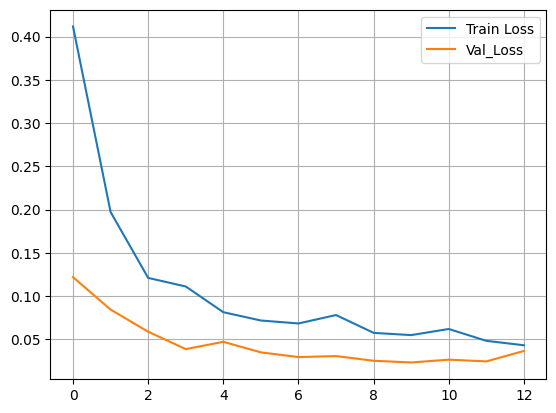

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label= 'Train Loss')
plt.plot(history.history['val_loss'], label= 'Val_Loss')
plt.grid()
plt.legend()
plt.show()

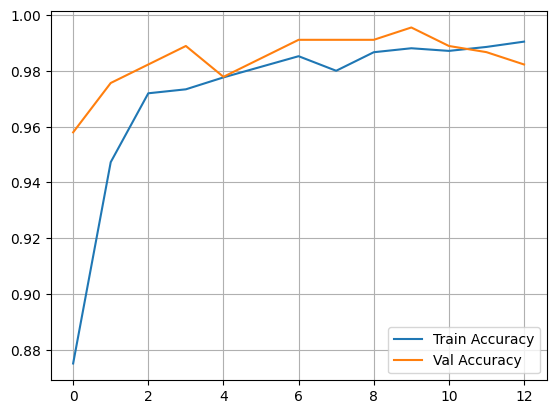

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label= 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label= 'Val Accuracy')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Save the model
model.save('resnet50.keras')

## EfficientNetB0 Model

In [ ]:
# EfficientNetB0
conv_base = EfficientNetB0(
    weights = 'imagenet',
    include_top = False,
)
conv_base.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input

# Model
input = Input(shape = (128,128,3))
x = preprocess_input(input)
x = conv_base(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation= 'sigmoid')(x)

model = Model(input, output)

In [ ]:
model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=15, callbacks= early_stop, class_weight= class_weight)

Epoch 1/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 76s 681ms/step - accuracy: 0.7250 - loss: 0.7051 - val_accuracy: 0.8916 - val_loss: 0.2547
Epoch 2/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - accuracy: 0.9370 - loss: 0.2823 - val_accuracy: 0.9181 - val_loss: 0.1968
Epoch 3/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 196ms/step - accuracy: 0.9473 - loss: 0.2287 - val_accuracy: 0.9358 - val_loss: 0.1718
Epoch 4/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 219ms/step - accuracy: 0.9556 - loss: 0.2005 - val_accuracy: 0.9248 - val_loss: 0.1781
Epoch 5/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 16s 234ms/step - accuracy: 0.9561 - loss: 0.1823 - val_accuracy: 0.9535 - val_loss: 0.1252
Epoch 6/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 189ms/step - accuracy: 0.9731 - loss: 0.1504 - val_accuracy: 0.9558 - val_loss: 0.1192
Epoch 7/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - accuracy: 0.9760 - loss: 0.1333 - val_accuracy: 0.9491 - val_loss: 0.1286
Epoch 8/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 188ms/step - accuracy: 0.9728 - loss: 0.1257 - val_accu

In [ ]:
# Prediction
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 968ms/step
              precision    recall  f1-score   support

           0       0.88      0.99      0.93        77
           1       1.00      0.97      0.99       374

    accuracy                           0.98       451
   macro avg       0.94      0.98      0.96       451
weighted avg       0.98      0.98      0.98       451

ROC-AUC: 0.9801375095492743
F1 score: 0.9851150202976996


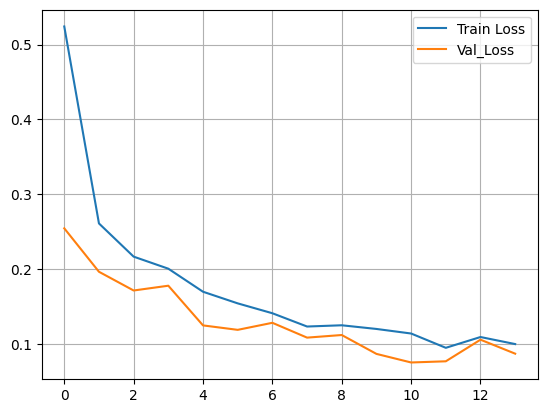

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label= 'Train Loss')
plt.plot(history.history['val_loss'], label= 'Val_Loss')
plt.grid()
plt.legend()
plt.show()

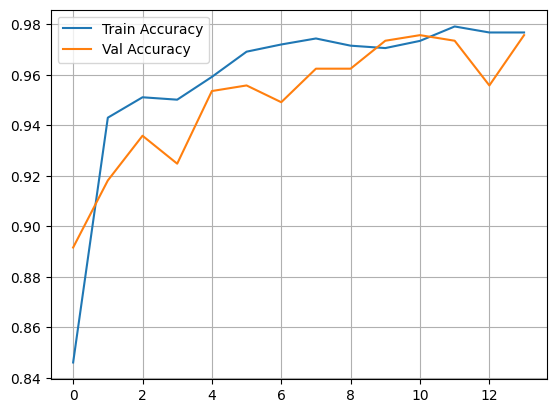

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label= 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label= 'Val Accuracy')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Save the model
model.save('efficientnetb0.keras')

Checking the best performance

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficient_preprocess

# ----- USER INPUTS -----
folders = [
    "/content/Dataset of Tuberculosis Chest X-rays Images/TB Chest X-rays",
    "/content/Dataset of Tuberculosis Chest X-rays Images/Normal Chest X-rays"
]

class_names = ['Normal', 'TB']

# Load models
vgg = load_model('/content/vgg16.keras')
resnet = load_model('/content/resnet50.keras')
efficient = load_model('/content/efficientnetb0.keras')

# Image size
img_size = 128

# Preprocessing
preprocess = {
    'vgg': vgg_preprocess,
    'resnet': resnet_preprocess,
    'efficient': efficient_preprocess
}

# ----- FUNCTION TO PREDICT PER FOLDER -----
def predict(model, preprocess_func, model_name):
    for folder in folders:
        folder_name = os.path.basename(folder)
        images = []

        for file in os.listdir(folder):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(folder, file)
                img = cv2.imread(img_path)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (img_size, img_size))
                images.append(img)

        images_array = np.array(images, dtype=np.float32)
        images_array = preprocess_func(images_array)

        preds = model.predict(images_array, batch_size=32)
        pred_labels = (preds > 0.5).astype(int).flatten()

        # Folder summary
        summary = {name:0 for name in class_names}
        for label in pred_labels:
            summary[class_names[label]] += 1

        print(f"\n--- Prediction Summary for {model_name} on folder: {folder_name} ---")
        print(f"Total images: {len(pred_labels)}")
        for key, value in summary.items():
            print(f"{key}: {value} images")
      print("---------------------------------------")


# ----- RUN FOR THREE MODELS -----
predict(vgg, preprocess['vgg'], "VGG16")
predict(resnet, preprocess['resnet'], "ResNet50")
predict(efficient, preprocess['efficient'], "EfficientNetB0")

78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step

--- Prediction Summary for VGG16 on folder: TB Chest X-rays ---
Total images: 2494
Normal: 6 images
TB: 2488 images
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step

--- Prediction Summary for VGG16 on folder: Normal Chest X-rays ---
Total images: 514
Normal: 472 images
TB: 42 images
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step

--- Prediction Summary for ResNet50 on folder: TB Chest X-rays ---
Total images: 2494
Normal: 0 images
TB: 2494 images
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step

--- Prediction Summary for ResNet50 on folder: Normal Chest X-rays ---
Total images: 514
Normal: 249 images
TB: 265 images
78/78 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step

--- Prediction Summary for EfficientNetB0 on folder: TB Chest X-rays ---
Total images: 2494
Normal: 60 images
TB: 2434 images
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 767ms/step

--- Prediction Summary for EfficientNetB0 on folder: Normal Chest X-rays ---
Total images: 514
Normal: 505 images
TB: 9 images


## Fine Tuning

In [ ]:
# EfficientNetB0
conv_base = EfficientNetB0(
    weights = 'imagenet',
    include_top = False,
)
conv_base.trainable = False

from tensorflow.keras.applications.efficientnet import preprocess_input

# Model
input = Input(shape = (128,128,3))
x = preprocess_input(input)
x = conv_base(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation= 'sigmoid')(x)

model = Model(input, output)

model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_ds, validation_data=val_ds, epochs=5, class_weight= class_weight)

Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 57s 493ms/step - accuracy: 0.6953 - loss: 0.7821 - val_accuracy: 0.9071 - val_loss: 0.2492
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 182ms/step - accuracy: 0.9378 - loss: 0.2907 - val_accuracy: 0.9071 - val_loss: 0.2307
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 180ms/step - accuracy: 0.9426 - loss: 0.2254 - val_accuracy: 0.9403 - val_loss: 0.1736
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 180ms/step - accuracy: 0.9554 - loss: 0.2091 - val_accuracy: 0.9226 - val_loss: 0.1830
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 219ms/step - accuracy: 0.9603 - loss: 0.1731 - val_accuracy: 0.9469 - val_loss: 0.1475


In [ ]:
# Unfreeze last few layers
for layer in conv_base.layers[-40:]:
    layer.trainable = True

# Re-compile with smaller LR and train
model.compile(optimizer=Adam(2e-5), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks= early_stop, class_weight= class_weight)

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 71s 574ms/step - accuracy: 0.8013 - loss: 0.4756 - val_accuracy: 0.8827 - val_loss: 0.2547
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - accuracy: 0.8781 - loss: 0.3141 - val_accuracy: 0.8717 - val_loss: 0.3035
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step - accuracy: 0.9137 - loss: 0.2666 - val_accuracy: 0.8761 - val_loss: 0.2917
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - accuracy: 0.9372 - loss: 0.2207 - val_accuracy: 0.9071 - val_loss: 0.2283
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - accuracy: 0.9556 - loss: 0.1692 - val_accuracy: 0.9336 - val_loss: 0.1837
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - accuracy: 0.9661 - loss: 0.1474 - val_accuracy: 0.9425 - val_loss: 0.1585
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - accuracy: 0.9675 - loss: 0.1549 - val_accuracy: 0.9668 - val_loss: 0.1190
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - accuracy: 0.9734 - loss: 0.1242 - val_accu

In [ ]:
# Prediction
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 527ms/step
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        77
           1       1.00      0.99      0.99       374

    accuracy                           0.99       451
   macro avg       0.97      0.99      0.98       451
weighted avg       0.99      0.99      0.99       451

ROC-AUC: 0.9933155080213903
F1 score: 0.9932705248990579


In [ ]:
# Save the model
model.save('finetuned_efficientnet.keras')

In [ ]:
# Export the model ( For Streamlit)
%%capture
model.export('/content/finetuned_efficientnet')

In [ ]:
# Predict on this finetuned model
finetuned_model = load_model('/content/finetuned_efficientnet.keras')

predict(finetuned_model, preprocess['efficient'], "FineTuned EfficientNetB0")

78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 102ms/step

--- Prediction Summary for FineTuned EfficientNetB0 on folder: TB Chest X-rays ---
Total images: 2494
Normal: 24 images
TB: 2470 images
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step

--- Prediction Summary for FineTuned EfficientNetB0 on folder: Normal Chest X-rays ---
Total images: 514
Normal: 514 images
TB: 0 images


# The fine-tuned EfficientNetB0 model outperforms the frozen base model in predictions and will therefore be used for deployment.